In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

final_output = pd.read_csv('04_final_output.csv')

final_output.head()

,symbol,timestamp,price
0,SBIN,2025-07-12T09:15:00Z,1222.66
1,SBIN,2025-07-12T09:15:00.005000Z,1550.06
2,TCS,2025-07-12T09:15:00.010000Z,1279.08
3,RELIANCE,2025-07-12T09:15:00.015000Z,2353.40
4,ITC,2025-07-12T09:15:00.020000Z,1173.88


In [2]:
print(final_output.dtypes)

final_output['timestamp'] = pd.to_datetime(final_output['timestamp'], format='ISO8601')

total_duplicates = final_output.duplicated().sum()
print(f"Total exact duplicate rows: {total_duplicates}")

print(final_output.describe())
print(f"Total records: {len(final_output)}")
print(f"Unique symbols: {final_output['symbol'].nunique()}")

symbol        object
timestamp     object
price        float64
dtype: object
Total exact duplicate rows: 0
              price
count  70250.000000
mean    1999.774364
std      578.125946
min     1000.030000
25%     1498.145000
50%     1999.555000
75%     2501.550000
max     2999.980000
Total records: 70250
Unique symbols: 7


In [3]:
duplicate_groups = final_output.groupby(['symbol', 'timestamp']).size().reset_index(name='occurrences')

duplicates = duplicate_groups[duplicate_groups['occurrences'] > 1]

print(f"Number of unique (symbol, timestamp) pairs with duplicates: {len(duplicates)}")
duplicates.head()

Number of unique (symbol, timestamp) pairs with duplicates: 2


,symbol,timestamp,occurrences
16076,HDFCBANK,2025-07-12 09:18:26.375000+00:00,2
32094,ITC,2025-07-12 09:16:09.985000+00:00,2


In [4]:
def calculate_price_metrics(group):
    min_price = group['price'].min()
    max_price = group['price'].max()
    price_shift = max_price - min_price
    return pd.Series({
        'min_price': min_price,
        'max_price': max_price,
        'price_shift': price_shift,
        'occurrences': len(group)
    })

duplication_metrics = final_output.groupby(['symbol', 'timestamp']).apply(calculate_price_metrics).reset_index()

duplication_metrics.head()

/var/folders/t2/0hbf5tzd7_n2dj30c1n896980000gn/T/ipykernel_54508/615045353.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplication_metrics = final_output.groupby(['symbol', 'timestamp']).apply(calculate_price_metrics).reset_index()


,symbol,timestamp,min_price,max_price,price_shift,occurrences
0,BAJFINANCE,2025-07-12 09:15:00.060000+00:00,1013.00,1013.00,0.0,1.0
1,BAJFINANCE,2025-07-12 09:15:00.065000+00:00,1319.32,1319.32,0.0,1.0
2,BAJFINANCE,2025-07-12 09:15:00.080000+00:00,1673.19,1673.19,0.0,1.0
3,BAJFINANCE,2025-07-12 09:15:00.145000+00:00,1465.58,1465.58,0.0,1.0
4,BAJFINANCE,2025-07-12 09:15:00.210000+00:00,2536.63,2536.63,0.0,1.0


Records with close timestamp proximity (within 100ms): 70074


,symbol,timestamp,price,timestamp_ns,time_diff_ms
13,BAJFINANCE,2025-07-12 09:15:00.065000+00:00,1319.32,1752311700065000000,4.999936
16,BAJFINANCE,2025-07-12 09:15:00.080000+00:00,1673.19,1752311700080000000,15.000064
29,BAJFINANCE,2025-07-12 09:15:00.145000+00:00,1465.58,1752311700145000000,64.999936
42,BAJFINANCE,2025-07-12 09:15:00.210000+00:00,2536.63,1752311700210000000,64.999936
58,BAJFINANCE,2025-07-12 09:15:00.290000+00:00,1219.30,1752311700290000000,80.000000



Duplicates with identical prices: 0
Duplicates with different prices: 2
Percentage with price variation: 100.00%


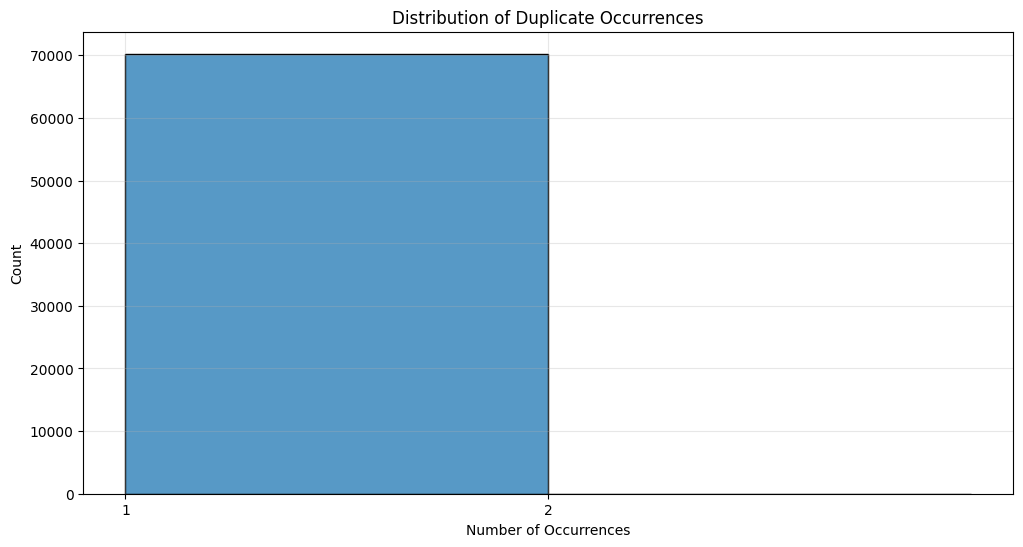

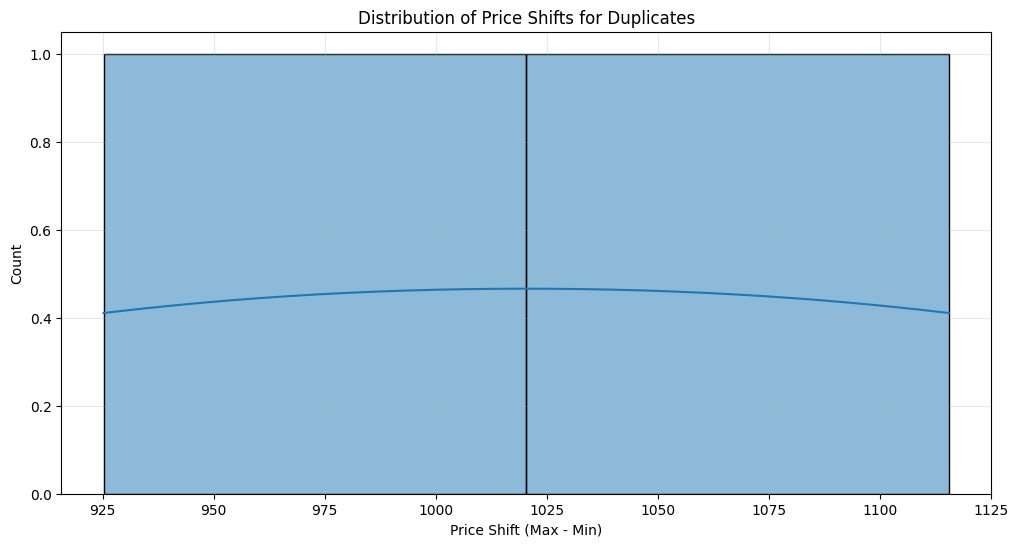

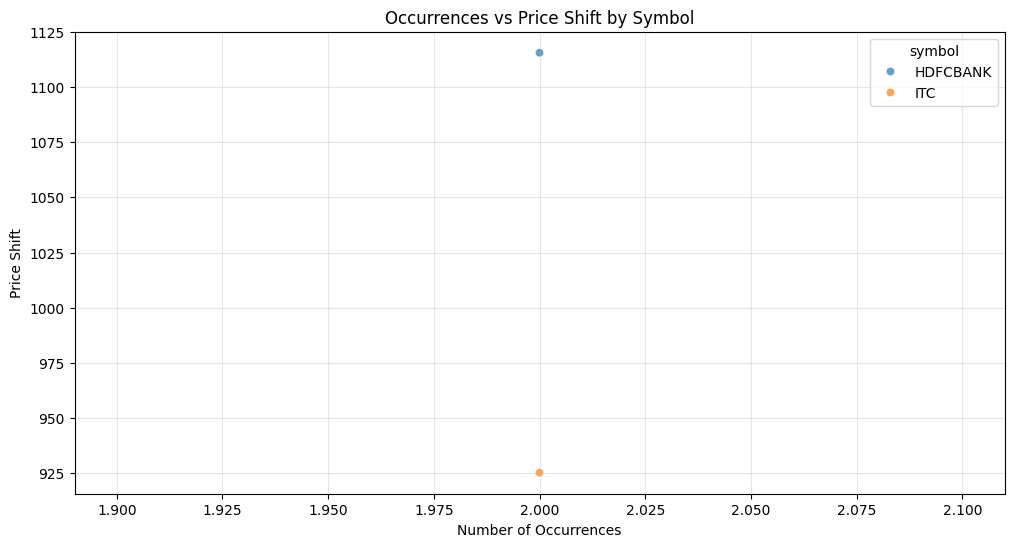

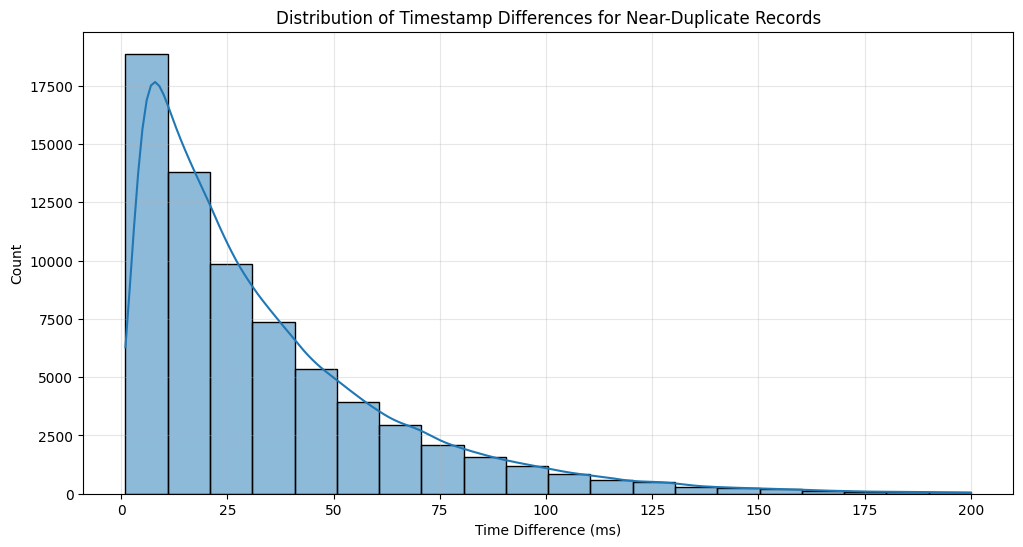

In [5]:
def analyze_timestamp_deviations(df, window_ms=200):
    df['timestamp_ns'] = df['timestamp'].astype(np.int64)
    
    df = df.sort_values(['symbol', 'timestamp_ns'])
    
    df['time_diff_ms'] = df.groupby('symbol')['timestamp_ns'].diff() / 1_000_000
    
    close_timestamps = df[(df['time_diff_ms'] > 0) & (df['time_diff_ms'] <= window_ms)]
    
    return close_timestamps

timestamp_deviations = analyze_timestamp_deviations(final_output)
print(f"Records with close timestamp proximity (within 100ms): {len(timestamp_deviations)}")
display(timestamp_deviations.head())

duplicate_price_analysis = duplication_metrics[duplication_metrics['occurrences'] > 1].copy()
duplicate_price_analysis['has_price_variation'] = duplicate_price_analysis['price_shift'] > 0

same_price = duplicate_price_analysis[duplicate_price_analysis['price_shift'] == 0].shape[0]
diff_price = duplicate_price_analysis[duplicate_price_analysis['price_shift'] > 0].shape[0]

print(f"\nDuplicates with identical prices: {same_price}")
print(f"Duplicates with different prices: {diff_price}")
if same_price + diff_price > 0:
    print(f"Percentage with price variation: {diff_price/(same_price+diff_price)*100:.2f}%")

plt.figure(figsize=(12, 6))
max_occurrences = int(duplication_metrics['occurrences'].max())
sns.histplot(duplication_metrics['occurrences'], bins=range(1, max_occurrences + 2))
plt.title('Distribution of Duplicate Occurrences')
plt.xlabel('Number of Occurrences')
plt.ylabel('Count')
plt.xticks(range(1, max_occurrences + 1))
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(duplication_metrics[duplication_metrics['price_shift'] > 0]['price_shift'], kde=True)
plt.title('Distribution of Price Shifts for Duplicates')
plt.xlabel('Price Shift (Max - Min)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=duplication_metrics[duplication_metrics['occurrences'] > 1], 
                x='occurrences', y='price_shift', hue='symbol', alpha=0.7)
plt.title('Occurrences vs Price Shift by Symbol')
plt.xlabel('Number of Occurrences')
plt.ylabel('Price Shift')
plt.grid(True, alpha=0.3)
plt.show()

if len(timestamp_deviations) > 0:
    plt.figure(figsize=(12, 6))
    sns.histplot(timestamp_deviations['time_diff_ms'], kde=True, bins=20)
    plt.title('Distribution of Timestamp Differences for Near-Duplicate Records')
    plt.xlabel('Time Difference (ms)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.show()

In [6]:
duplication_analysis = duplication_metrics.copy()


duplication_analysis = duplication_analysis[['symbol', 'timestamp', 'occurrences', 'price_shift', 'min_price', 'max_price']]

duplication_analysis.to_csv('duplication_analysis.csv', index=False)

print(f"Duplication analysis saved to duplication_analysis.csv")
duplication_analysis.head()

Duplication analysis saved to duplication_analysis.csv


,symbol,timestamp,occurrences,price_shift,min_price,max_price
0,BAJFINANCE,2025-07-12 09:15:00.060000+00:00,1.0,0.0,1013.00,1013.00
1,BAJFINANCE,2025-07-12 09:15:00.065000+00:00,1.0,0.0,1319.32,1319.32
2,BAJFINANCE,2025-07-12 09:15:00.080000+00:00,1.0,0.0,1673.19,1673.19
3,BAJFINANCE,2025-07-12 09:15:00.145000+00:00,1.0,0.0,1465.58,1465.58
4,BAJFINANCE,2025-07-12 09:15:00.210000+00:00,1.0,0.0,2536.63,2536.63


In [7]:
symbol_summary = duplication_analysis.groupby('symbol').agg({
    'occurrences': ['count', 'mean', 'max'],
    'price_shift': ['mean', 'max', 'sum']
}).reset_index()

symbol_summary.columns = ['symbol', 'duplicate_count', 'avg_occurrences', 'max_occurrences', 
                          'avg_price_shift', 'max_price_shift', 'total_price_shift']
print("Summary statistics by symbol:")
symbol_summary

Summary statistics by symbol:


,symbol,duplicate_count,avg_occurrences,max_occurrences,avg_price_shift,max_price_shift,total_price_shift
0,BAJFINANCE,10025,1.000000,1.0,0.000000,0.00,0.00
1,HDFCBANK,10229,1.000098,2.0,0.109054,1115.51,1115.51
2,INFY,9881,1.000000,1.0,0.000000,0.00,0.00
3,ITC,9901,1.000101,2.0,0.093448,925.23,925.23
4,RELIANCE,10037,1.000000,1.0,0.000000,0.00,0.00
5,SBIN,10123,1.000000,1.0,0.000000,0.00,0.00
6,TCS,10052,1.000000,1.0,0.000000,0.00,0.00
